# Latent Gaussian Mixture Modelsのデモ

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.mixture import GaussianMixture
import matplotlib.cm as cm
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import os
os.environ["OMP_NUM_THREADS"] = "2"

In [2]:
# 共通設定
ticker = "^N225"
# str_prodはデータを取得する期間（例: 1d、5d、1mo、3mo、1y、2y、5y、10y、ytd、max）
str_prod = "18mo"
# str_itvlはデータの間隔（例: 1m、2m、5m、15m、30m、60m、90m、1h、1d、5d、1wk、1mo、3mo）
str_itvl = "1d"
# matplotlibのカラーマップ
str_colormap = 'viridis'

In [3]:
def colored_plot(x, y, labels, ticker):
    unique_labels = np.unique(labels)
    colors = cm.get_cmap(str_colormap, len(unique_labels))
    color_map = {label: colors(i) for i, label in enumerate(unique_labels)}
    # プロット開始
    plt.figure(figsize=(10, 5))
    # ラベルの変化点で分割して線を描く
    start = 0
    for i in range(1, len(labels)):
        if labels[i] != labels[i-1]:
            plt.plot(x[start:i+1], y[start:i+1], color=color_map[labels[i-1]], label=f'label {labels[i-1]}')
            start = i
    # 最後の区間
    plt.plot(x[start:], y[start:], color=color_map[labels[-1]], label=f'label {labels[-1]}')
    plt.xlabel("Date")
    plt.ylabel("Price")
#    plt.legend()
    plt.title(ticker+" Close Price by Regime")
    plt.grid(True)
    plt.show()

In [4]:
df = yf.download(ticker, period=str_prod, interval=str_itvl, multi_level_index=False).reset_index()
data = np.column_stack((df['Close'].pct_change().dropna(), df['Volume'].pct_change().dropna()))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
# データの正規化
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
data_normalized = (data - mean) / std

In [6]:
# LGMMモデルのあてはめ
lgmm = GaussianMixture(n_components=3, random_state=42)
lgmm.fit(data_normalized)
labels = lgmm.predict(data_normalized)

C:\Users\nicjp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


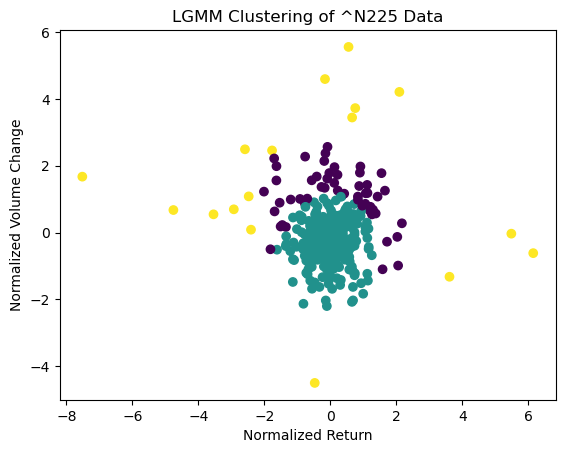

BIC Score: 1911.17


In [7]:
# 散布図の表示
plt.scatter(data_normalized[:, 0], data_normalized[:, 1], c=labels, cmap=str_colormap)
plt.title('LGMM Clustering of '+ticker+' Data')
plt.xlabel('Normalized Return')
plt.ylabel('Normalized Volume Change')
plt.savefig('spy_lgmm_plot.png')
plt.show()
print(f"BIC Score: {lgmm.bic(data_normalized):.2f}")

C:\Users\nicjp\AppData\Local\Temp\ipykernel_18808\3436875532.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(str_colormap, len(unique_labels))


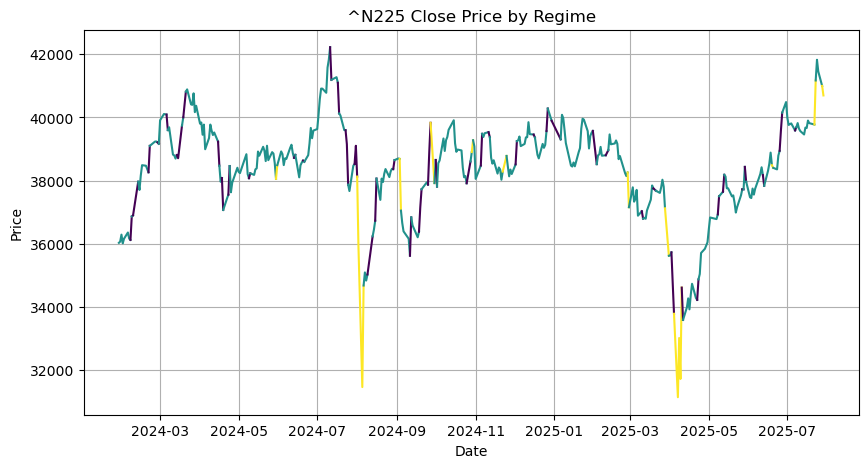

In [8]:
colored_plot(df['Date'],df['Close'],labels,ticker)